# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

from scipy.stats import chi2, chi2_contingency

from classification_utils import chi_test, chi_test_new, find_boolean_features, drop_correlated_features, remove_outliers

## Loading the data

In [2]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the customer will leave [yes / no]

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

### Loyalty
The distribution is right-skewed, peak around the 12th month might indicate past sale or a marketing campaign. The longest staying customer is with the company for 5 years. 

<AxesSubplot:xlabel='months', ylabel='Count'>

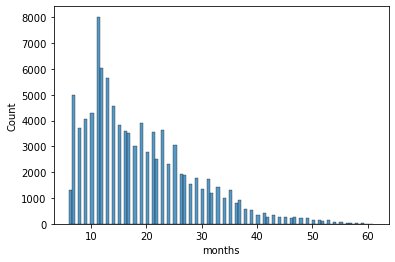

In [3]:
sns.histplot(df['months'])

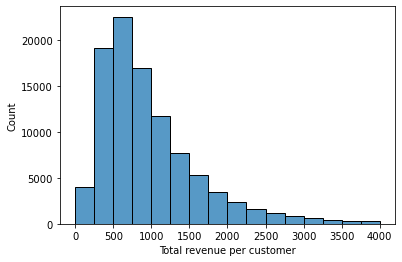

In [4]:
sns.histplot(df['totrev'], binrange=(0, 4000), binwidth=250)
plt.xlabel("Total revenue per customer")
plt.show()

### Company Revenue
As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [5]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

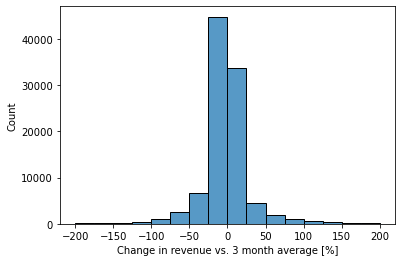

In [6]:
sns.histplot(df['change_rev'], binrange=(-200, 200), binwidth=25)
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

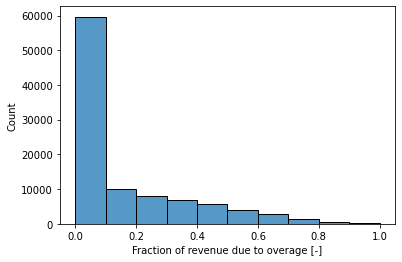

In [7]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(df['overrev_ratio'], binrange=(0, 1), binwidth=0.1)
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()

Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop of demand might be correlated with churn.

<AxesSubplot:xlabel='actsubs_ratio', ylabel='Count'>

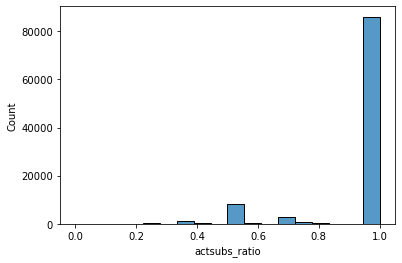

In [8]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(df['actsubs_ratio'])

### Customers social status
Client income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. Strong correlations are expected between these features, and perhaps some of them could be removed.

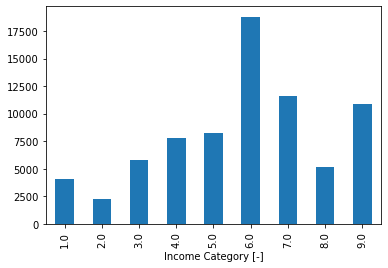

In [9]:
df['income'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Income Category [-]")
plt.show()

### Household information
How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

<AxesSubplot:xlabel='totmrc_Mean', ylabel='Count'>

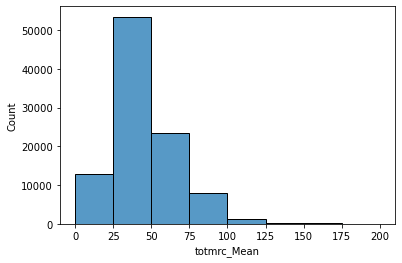

In [10]:
sns.histplot(df['totmrc_Mean'], binrange=(0, 200), binwidth=25)

### Quality of service
Median time of a call with customer service is 2 min which might mean the issues are resolved relatively quickly.

In [11]:
(df['ccrndmou_Mean'] / df['custcare_Mean']).median()

2.000000003

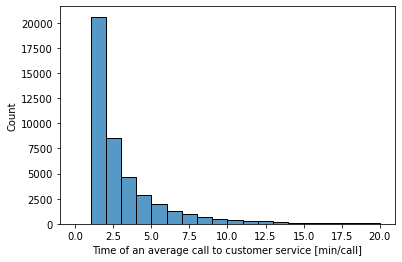

In [12]:
sns.histplot(df['ccrndmou_Mean'] / df['custcare_Mean'], binrange=(0, 20), binwidth=1)
plt.xlabel("Time of an average call to customer service [min/call]")
plt.show()

High percentage of failed calls or old equipment could indicate low quality of service and influence customer churn. It does not matter whether headset is refurbished or new, churn value is evenly distributed. 

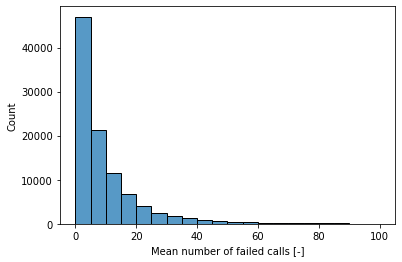

In [13]:
failed_calls = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
sns.histplot(failed_calls, binrange=(0, 100), binwidth=5)
plt.xlabel("Mean number of failed calls [-]")
plt.show()

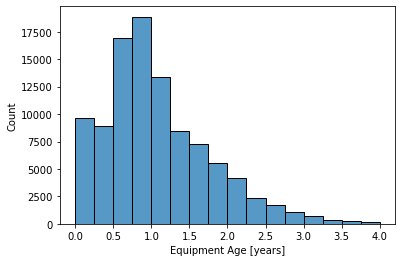

In [14]:
sns.histplot(df['eqpdays'] / 365, binrange=(0, 4), binwidth=0.25)
plt.xlabel("Equipment Age [years]")
plt.show()

### Other
Churn is more or less equally distributed across all areas of operation. Non-uniform distribution could undicate e.g. new strong competition. 

In [15]:
df['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

## Feature Engineering

In [280]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

In [281]:
X.shape

(100000, 101)

### Looking for correlations
#### Categorical Features

In [282]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [283]:
# Following their chi test vs. churn
X.drop(columns=['truck', 'rv'], inplace=True)

# Droping biased or unnecessary features
X.drop(columns=['ethnic', 'Customer_ID'], inplace=True)

In [284]:
maybe_dependent_cols = ['crclscod', 'asl_flag', 'prizm_social_one', 'ownrent', 'lor', 'dwlltype', 'dwllsize', 'numbcars', 
                        'HHstatin', 'forgntvl', 'creditcd']
income_chi_table = chi_test_new(X, maybe_dependent_cols, X['income'])
X.drop(columns=income_chi_table.loc[income_chi_table['correlated'] == True].index, inplace=True)
cat_features = X.select_dtypes(include='object').columns

In [285]:
income_chi_table

,stat,p,dof,correlated
crclscod,4633.309034,0.000000e+00,400.0,True
asl_flag,1677.284510,0.000000e+00,8.0,True
prizm_social_one,3768.817886,0.000000e+00,32.0,True
ownrent,1350.243850,3.237428e-286,8.0,True
lor,756.228233,6.284631e-93,120.0,True
dwlltype,2810.454203,0.000000e+00,8.0,True
dwllsize,3530.142461,0.000000e+00,112.0,True
numbcars,359.835321,9.182754e-67,16.0,True
HHstatin,892.501324,2.961795e-161,40.0,True
forgntvl,761.451501,4.168882e-159,8.0,True


In [286]:
result = chi_test_new(X, cat_features, y)
X.drop(columns=result.loc[result['correlated'] == False].index, inplace=True)

In [287]:
result

,stat,p,dof,correlated
new_cell,2.727493,2.557010e-01,2.0,False
area,269.524041,8.530675e-47,18.0,True
dualband,291.115278,8.328702e-63,3.0,True
refurb_new,100.841399,9.965157e-24,1.0,True
hnd_webcap,411.901711,3.603129e-90,2.0,True
marital,81.039612,1.048883e-16,4.0,True
infobase,21.928076,2.830622e-06,1.0,True
kid0_2,9.160101,2.473489e-03,1.0,True
kid3_5,2.118470,1.455319e-01,1.0,False
kid6_10,0.424968,5.144683e-01,1.0,False


#### Numerical features
Continous numerical features are also investigated looking for correlations.

(100000, 59)


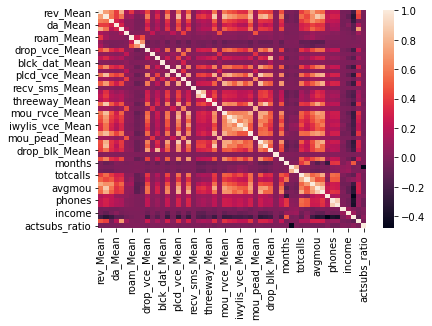

In [288]:
X, _ = drop_correlated_features(X, threshold=0.9)
num_features = X.select_dtypes(include='number').columns
sns.heatmap(X[num_features].corr())
print(X.shape)

In [289]:
# TODO: These are not ordinal features

def find_ordinal_features(X):
    """Both categorical and numerical columns can be ordinal. E.g. size of T-shirts: 'S', 'M', 'L',
    or income category: 0, 1, 2, ..., 7 - each corresponding to different brackets"""
    ordinal_features = []
    cat_features = X.select_dtypes(include='object').columns
    for col in cat_features:
        if len(X[col].dropna().unique()) > 2:
            ordinal_features.append(col)
    return ordinal_features

In [290]:
ordinal_features = find_ordinal_features(X)

In [291]:
X['area'].unique()

array(['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA',
       'GREAT LAKES AREA', 'NEW ENGLAND AREA', 'DALLAS AREA',
       'CENTRAL/SOUTH TEXAS AREA', 'TENNESSEE AREA', 'MIDWEST AREA',
       'PHILADELPHIA AREA', 'OHIO AREA', 'HOUSTON AREA', 'SOUTHWEST AREA',
       'NEW YORK CITY AREA', 'ATLANTIC SOUTH AREA', 'SOUTH FLORIDA AREA',
       'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA',
       'NORTH FLORIDA AREA', nan, 'LOS ANGELES AREA'], dtype=object)

In [292]:
X['dualband'].unique()

array(['Y', 'N', 'T', 'U', nan], dtype=object)

In [293]:
X['marital'].unique()

array(['S', 'M', 'A', 'U', 'B', nan], dtype=object)

## Data Preprocessing
### Looking for duplicates

In [294]:
X.duplicated().sum()

0

### Looking for outliers

In [295]:
X[num_features].describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,...,avgmou,avgqty,hnd_price,phones,models,adults,income,eqpdays,overrev_ratio,actsubs_ratio
count,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99109.000000,99109.000000,100000.000000,...,100000.000000,100000.000000,99153.000000,99999.000000,99999.000000,76981.000000,74564.000000,99999.000000,99631.000000,100000.000000
mean,58.719985,513.559937,46.179136,0.888828,41.072247,0.261318,1.286405,-13.933818,-1.021067,5.955085,...,483.726493,173.554507,101.875763,1.787118,1.545825,2.530326,5.783112,391.932309,0.151300,0.933202
std,46.291677,525.168140,23.623489,2.177619,97.296150,3.126531,14.711374,276.087509,50.363209,8.954715,...,438.485213,167.824576,61.005671,1.313977,0.898395,1.452819,2.182132,256.482193,0.212479,0.172145
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.740000,0.000000,...,0.000000,0.000000,9.989998,1.000000,1.000000,1.000000,1.000000,-5.000000,0.000000,0.000000
25%,33.260000,150.750000,30.000000,0.000000,0.000000,0.000000,0.000000,-87.000000,-7.365000,0.666667,...,176.140000,64.090000,29.989990,1.000000,1.000000,1.000000,4.000000,212.000000,0.000000,1.000000
50%,48.195000,355.500000,44.990000,0.247500,2.750000,0.000000,0.000000,-6.250000,-0.315000,3.000000,...,360.190000,127.500000,99.989990,1.000000,1.000000,2.000000,6.000000,342.000000,0.025579,1.000000
75%,70.750000,703.000000,59.990000,0.990000,42.000000,0.000000,0.235000,63.000000,1.642500,7.666667,...,655.670000,228.570000,149.989990,2.000000,2.000000,3.000000,7.000000,530.000000,0.259949,1.000000
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,423.540000,3685.200000,31219.250000,9963.657500,232.666667,...,7040.130000,3017.110000,499.989990,28.000000,16.000000,6.000000,9.000000,1823.000000,3.937152,1.000000


In [296]:
X = remove_outliers(X, num_features)

In [297]:
X[num_features].describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,...,avgmou,avgqty,hnd_price,phones,models,adults,income,eqpdays,overrev_ratio,actsubs_ratio
count,98020.000000,97829.000000,98634.000000,97877.000000,97838.000000,99105.000000,99289.000000,97351.000000,98126.000000,98105.000000,...,98212.000000,98204.000000,98806.000000,97839.000000,98608.000000,76981.000000,74564.000000,98980.000000,98565.000000,98043.000000
mean,55.090236,473.589550,45.063724,0.683103,31.700031,0.121360,0.915138,-11.846413,-1.870323,5.128762,...,451.802258,159.953762,100.859169,1.661096,1.487800,2.530326,5.783112,382.292170,0.143231,0.945735
std,32.766443,429.989653,20.665347,1.217362,57.040407,0.631768,3.368060,198.435747,28.035872,6.147522,...,366.703949,130.173380,58.514335,0.961347,0.747609,1.452819,2.182132,238.981383,0.197888,0.148557
min,-6.167500,0.000000,-11.290000,0.000000,0.000000,0.000000,0.000000,-842.000000,-152.000000,0.000000,...,0.000000,0.000000,9.989998,1.000000,1.000000,1.000000,1.000000,-5.000000,0.000000,0.428571
25%,33.165000,147.500000,30.000000,0.000000,0.000000,0.000000,0.000000,-84.250000,-7.275000,0.666667,...,173.207500,63.000000,29.989990,1.000000,1.000000,1.000000,4.000000,210.000000,0.000000,1.000000
50%,47.408750,346.750000,44.990000,0.247500,2.250000,0.000000,0.000000,-6.250000,-0.315000,3.000000,...,352.405000,124.920000,99.989990,1.000000,1.000000,2.000000,6.000000,339.000000,0.022593,1.000000
75%,68.737500,674.750000,59.990000,0.742500,38.500000,0.000000,0.235000,61.250000,1.485000,7.333333,...,633.737500,220.742500,149.989990,2.000000,2.000000,3.000000,7.000000,520.000000,0.249560,1.000000
max,197.530000,2088.750000,117.005000,7.260000,332.750000,9.625000,45.270000,814.000000,150.000000,32.666667,...,1798.640000,676.870000,249.989990,5.000000,4.000000,6.000000,9.000000,1161.000000,0.788597,1.000000


### Dropping NaNs

In [298]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 10000]  # Is one of the dropped features crucial?

hnd_webcap    10189
adults        23019
infobase      22079
income        25436
dtype: int64

In [299]:
nans_per_feature.sort_values(ascending=False).head(10)

income           25436
adults           23019
infobase         22079
hnd_webcap       10189
change_mou        2649
mou_opkv_Mean     2307
mou_Mean          2171
ovrmou_Mean       2162
phones            2161
mou_rvce_Mean     2124
dtype: int64

In [300]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 10000].index)  # drop features which have more than 20% NaNs
cols_to_drop = ['adults', 'infobase', 'hnd_webcap']
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['adults', 'infobase', 'hnd_webcap']
Before dropping rows with NaNs: (100000, 56)
After dropping rows with NaNs: (58090, 56)


### Looking for class imbalance

In [301]:
y.value_counts()

0    29659
1    28431
Name: churn, dtype: int64

### Identifying numerical, categorical, text features

In [302]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [303]:
len(num_features), len(cat_features)

(51, 5)

## Predicting churn

### Splitting the data

In [304]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [305]:
X_train.shape

(46472, 56)

### Training the model

In [306]:
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [307]:
X[cat_features].describe()

,area,dualband,refurb_new,marital,kid0_2
count,58090,58090,58090,58090,58090
unique,19,3,2,5,2
top,NEW YORK CITY AREA,Y,N,M,U
freq,6171,42768,50337,24930,54901


In [267]:
X[num_features].describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,...,totrev,avgrev,avgmou,avgqty,hnd_price,phones,models,eqpdays,overrev_ratio,actsubs_ratio
count,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,...,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000,75171.000000
mean,48.204244,364.010900,42.383328,0.566715,23.125188,0.089226,0.788017,-8.626543,-0.889036,4.115497,...,865.443282,49.446419,365.327677,130.297518,97.778366,1.560070,1.397560,411.195341,0.119716,0.948291
std,24.874136,308.661676,18.505779,1.066937,44.967669,0.521343,2.981987,166.253163,22.525319,5.091368,...,528.290147,22.629748,281.324515,100.680617,58.112547,0.872087,0.662754,239.424009,0.180692,0.146312
min,-6.167500,0.000000,-6.167500,0.000000,0.000000,0.000000,0.000000,-842.000000,-148.262500,0.000000,...,21.780000,2.910000,0.000000,0.000000,9.989998,1.000000,1.000000,-4.000000,0.000000,0.500000
25%,31.605000,125.000000,29.990000,0.000000,0.000000,0.000000,0.000000,-70.750000,-5.122500,0.666667,...,488.180000,33.910000,151.365000,55.170000,29.989990,1.000000,1.000000,240.000000,0.000000,1.000000
50%,42.117500,286.000000,40.232500,0.000000,0.500000,0.000000,0.000000,-5.250000,-0.270000,2.333333,...,735.960000,44.750000,297.220000,105.830000,99.989990,1.000000,1.000000,364.000000,0.003821,1.000000
75%,59.463750,524.500000,50.000000,0.742500,26.250000,0.000000,0.195000,52.250000,1.057500,5.666667,...,1105.250000,60.140000,511.060000,180.415000,149.989990,2.000000,2.000000,562.000000,0.194671,1.000000
max,196.287500,2065.500000,116.682500,7.177500,332.750000,9.555000,45.270000,814.000000,150.000000,32.666667,...,3589.020000,166.080000,1784.370000,676.230000,249.989990,5.000000,4.000000,1161.000000,0.788470,1.000000


In [319]:
%%time
ct = make_column_transformer((MinMaxScaler(), num_features),
                             (OneHotEncoder(handle_unknown='ignore'), cat_features),
#                              (SelectKBest(chi2, k=10)),
                             n_jobs=-1,
                             verbose=False)

pipeline = Pipeline(
    steps=[("preprocessor", ct), ("regressor", GradientBoostingClassifier())] # n_estimators=200, learning_rate=1
)

# ("regressor", RandomForestClassifier(n_estimators=10, max_features=3, random_state=42, min_samples_leaf=1))
# ("regressor", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.2))

    
# Training the model
pipeline.fit(X_train, y_train)

Wall time: 47.5 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean',
       'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean',
       'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean...
       'drop_blk_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs',
       'actvsubs', 'totcalls', 'totrev', 'avgrev', 'avgmou', 'avgqty',
       'hnd_price', 'phones', 'models', 'income', 'eqpdays', 'overrev_ratio',
       'actsubs_ratio'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                  

In [320]:
# Train Inference
y_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

In [321]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.65
Train Precision: 0.63
Train Recall: 0.65

Validation Accuracy: 0.63
Validation Precision: 0.62
Validation Recall: 0.64


## Error Analysis / Postprocessing

In [ ]:
feature_names = X_train.columns
feature_importances = pipeline.steps[1][1].feature_importances_

importance_df = pd.DataFrame({"name":feature_names, "importance":feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.plot(kind='bar', x='name')
plt.show()